In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import  Audio

from scipy.io import wavfile

import warnings as kxe_kxe
kxe_kxe.filterwarnings('ignore')

In [509]:
data_folder = 'data/'
sound1_filename = 'corrupt_sound1.wav'
sound2_filename = 'corrupt_sound2.wav'

# Чтение файлов

In [510]:
rate1, data1 = wavfile.read(data_folder + sound1_filename)
rate2, data2 = wavfile.read(data_folder + sound2_filename)

# Вывод информации о файлах

In [511]:
print(f"Файл 1: Частота дискретизации = {rate1} Гц, Длительность = {len(data1)/rate1:.2f} секунд")
print(f"Файл 2: Частота дискретизации = {rate2} Гц, Длительность = {len(data2)/rate2:.2f} секунд")

Файл 1: Частота дискретизации = 48000 Гц, Длительность = 21.85 секунд
Файл 2: Частота дискретизации = 48000 Гц, Длительность = 21.85 секунд


# Визуализация временного представления сигналов

Временное представление corrupt_sound1:


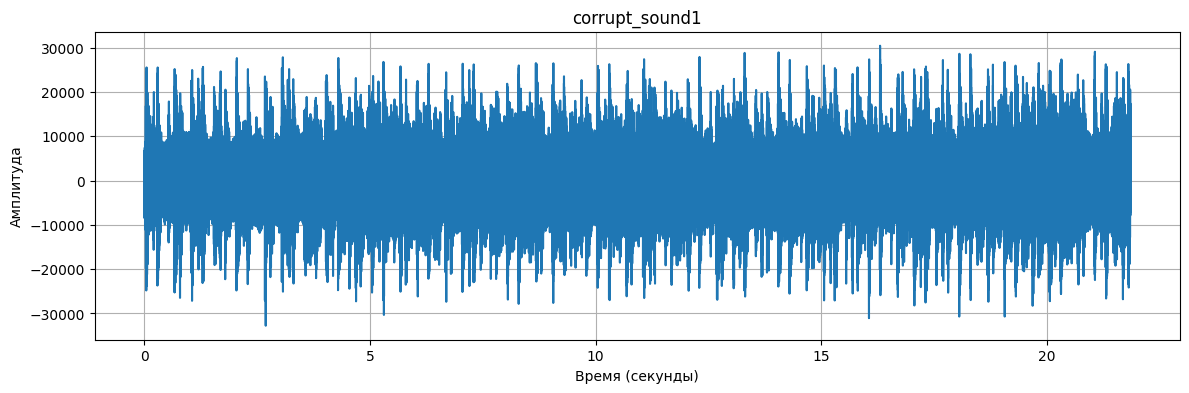

Временное представление corrupt_sound2:


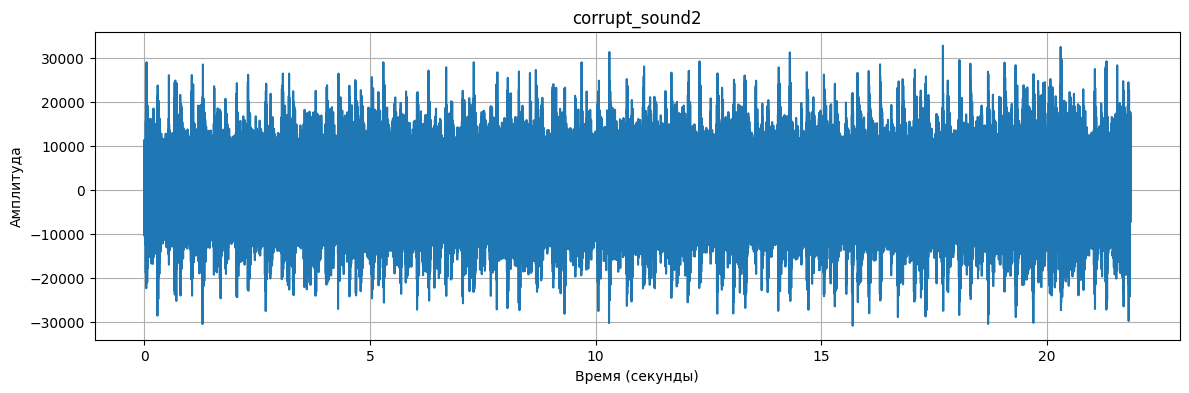

In [524]:
def plot_time_domain(signal, rate, title):
    plt.figure(figsize=(14, 4))
    plt.plot(np.arange(len(signal))/rate, signal)
    plt.title(title)
    plt.xlabel('Время (секунды)')
    plt.ylabel('Амплитуда')
    plt.grid(True)
    plt.show()
    
print("Временное представление corrupt_sound1:")
plot_time_domain(data1, rate1, "corrupt_sound1")

print("Временное представление corrupt_sound2:")
plot_time_domain(data2, rate2, "corrupt_sound2")

# Напишем дискретное преобразование Фурье своими дряблыми ручонками

In [ ]:
def dft_manual(signal, n_fft):
    """
    Ручное вычисление дискретного преобразования Фурье (DFT)
    
    Parameters:
    signal (array): Входной сигнал
    n_fft (int): Длина DFT
    
    Returns:
    array: Амплитудный спектр сигнала
    """
    # Подготовка сигнала (обрезка или дополнение нулями)
    signal_padded = np.zeros(n_fft)
    signal_padded[:min(len(signal), n_fft)] = signal[:n_fft]
    
    # Вычисление DFT через матричное умножение
    N = n_fft
    n = np.arange(N)
    k = np.arange(N).reshape((N, 1))
    exponents = np.exp(-2j * np.pi * k * n / N)  # Формула DFT
    fft_spectrum_complex = np.dot(exponents, signal_padded)
    fft_spectrum = np.abs(fft_spectrum_complex[:N//2])  # Первая половина спектра
    
    return fft_spectrum

def idft_manual(fft_spectrum):
    """
    Ручное вычисление обратного DFT
    
    Parameters:
    fft_spectrum (array): Полный комплексный спектр
    
    Returns:
    array: Восстановленный сигнал
    """
    N = len(fft_spectrum)
    n = np.arange(N)
    k = np.arange(N).reshape((N, 1))
    exponents = np.exp(2j * np.pi * k * n / N)
    signal_complex = np.dot(exponents, fft_spectrum) / N
    
    return signal_complex.real

# Напишем функцию, чтобы искать пики в спектрограмму

In [516]:
def find_peaks(y, threshold=0, min_distance=1):
    """
    Поиск локальных максимумов в массиве
    
    Parameters:
    y (array): Массив значений
    threshold (float): Минимальная амплитуда пика
    min_distance (int): Минимальное расстояние между пиками
    
    Returns:
    list: Индексы пиков
    """
    peaks = []
    last_peak_idx = -np.inf
    
    for i in range(1, len(y)-1):
        # Проверка локального максимума
        if y[i] > y[i-1] and y[i] > y[i+1]:
            # Порог амплитуды
            if y[i] > threshold:
                # Минимальное расстояние между пиками
                if i - last_peak_idx >= min_distance:
                    peaks.append(i)
                    last_peak_idx = i
    
    return peaks

# Сама функция спектрограммы

In [ ]:
def compute_and_plot_fft(signal, rate, title, n_fft=1024, n_peaks=5, threshold_factor=0):
    """
    Вычисляет и визуализирует спектр сигнала с отображением локальных максимумов
    
    Parameters:
    signal (array): Входной сигнал
    rate (int): Частота дискретизации
    title (str): Заголовок графика
    n_fft (int): Длина DFT
    n_peaks (int): Количество отображаемых пиков
    threshold_factor (float): Порог для фильтрации слабых пиков (0-1)
    """
    # Вычисление спектра через ручную DFT
    fft_spectrum = dft_manual(signal, n_fft)
    
    # Определение шкалы частот
    freq = np.linspace(0, rate/2, len(fft_spectrum))
    
    # Поиск пиков через собственную реализацию
    max_amp = max(fft_spectrum)
    peaks_idx = find_peaks(
        fft_spectrum,
        threshold=max_amp * threshold_factor,
        min_distance=5
    )
    
    # Сортировка пиков по амплитуде и выборка топ-N
    peaks_with_amp = [(freq[i], fft_spectrum[i]) for i in peaks_idx]
    peaks_with_amp.sort(key=lambda x: x[1], reverse=True)
    selected_peaks = peaks_with_amp[:n_peaks]
    
    # Визуализация
    plt.figure(figsize=(14, 6))
    plt.plot(freq, fft_spectrum, label='Спектр')
    
    # Отображение пиков
    peak_freqs, peak_amps = zip(*selected_peaks) if selected_peaks else ([], [])
    plt.plot(peak_freqs, peak_amps, 'rx', markersize=10, label=f'Топ {len(selected_peaks)} пиков')
    
    # Аннотации
    for freq_val, amp_val in selected_peaks:
        plt.annotate(f'{freq_val:.1f} Гц', 
                     xy=(freq_val, amp_val),
                     xytext=(5, 5), 
                     textcoords='offset points',
                     fontsize=9,
                     bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))
    
    plt.title(f"Спектр {title}")
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Амплитуда')
    plt.grid(True)
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    return peak_freqs, fft_spectrum

# Реализуем режекторный фильтр

In [ ]:
def rejector(fft_spectrum, rate, freqs, bandwidth=1):
    """
    Ручная реализация режекторного фильтра
    
    Parameters:
    fft_spectrum (array): Полный комплексный спектр
    rate (int): Частота дискретизации
    freqs (list): Список частот для фильтрации
    bandwidth (int): Ширина полосы фильтрации (Гц)
    
    Returns:
    array: Отфильтрованный спектр
    """
    N = len(fft_spectrum)
    dk = int(bandwidth * N / rate)
    
    for freq in freqs:
        k0 = int(freq * N / rate)
        for k in range(k0 - dk, k0 + dk + 1):
            if 0 <= k < N:
                fft_spectrum[k] = 0
                # Обнуление соответствующей отрицательной частоты
                if k != 0 and k != N//2 and N - k < N:
                    fft_spectrum[N - k] = 0
                    
    return fft_spectrum

def process_signal(signal, rate, noise_ranges, chunk_size=4096, bandwidth=1):
    """
    Обработка сигнала с удалением шума методом DFT
    
    Parameters:
    signal (array): Входной сигнал
    rate (int): Частота дискретизации
    noise_ranges (list): Список частот шума
    chunk_size (int): Размер фрагмента для обработки
    bandwidth (int): Ширина полосы фильтрации (Гц)
    
    Returns:
    array: Очищенный сигнал
    """
    # Разбиение на фрагменты
    chunks = [signal[i:i+chunk_size] for i in range(0, len(signal), chunk_size)]
    
    cleaned_chunks = []
    for chunk in chunks:
        # Прямое DFT
        fft_spectrum = dft_manual(chunk, n_fft=chunk_size)
        
        # Применение фильтра
        filtered_fft = rejector(fft_spectrum, rate, noise_ranges, bandwidth)
        
        # Обратное DFT
        cleaned_chunk = idft_manual(filtered_fft)
        
        # Преобразование к исходному типу данных
        cleaned_chunk = cleaned_chunk.astype(chunk.dtype)
        cleaned_chunks.append(cleaned_chunk)
    
    # Объединение фрагментов
    return np.concatenate(cleaned_chunks)

# corrupt_sound1

## Разбиение на фрагменты с окном Ханна


In [ ]:
def split_with_window(signal, chunk_size=4096):
    """
    Разбивает сигнал на фрагменты с перекрытием 50% и применяет окно Ханнинга
    
    Parameters:
    signal (array): Входной сигнал
    chunk_size (int): Размер фрагмента
    
    Returns:
    list: Список фрагментов сигнала с применённым окном
    """
    chunks = []
    
    # Создание окна Ханнинга вручную
    n = np.arange(chunk_size)
    window = 0.5 * (1 - np.cos(2 * np.pi * n / (chunk_size - 1)))  # Формула окна Ханнинга
    
    for i in range(0, len(signal), chunk_size // 2):  # Перекрытие 50%
        chunk = signal[i:i+chunk_size]
        
        # Дополнение нулями без использования np.pad
        if len(chunk) < chunk_size:
            padded_chunk = np.zeros(chunk_size)
            padded_chunk[:len(chunk)] = chunk
            chunk = padded_chunk
            
        chunks.append(chunk * window)  # Применение окна
    
    return chunks

chunks = split_with_window(data1)

# Функция вычисления корреляции

Вроде бы не очень запрещено

In [ ]:
def compute_correlation(chunk1, chunk2):
    """Вычисляет корреляцию между двумя фрагментами"""
    return np.corrcoef(chunk1, chunk2)[0, 1]

## Анализ корреляции и фильтрация

In [ ]:
cleaned_chunks = []
for i, chunk in enumerate(chunks):
    # Прямое FFT
    fft_chunk = dft_manual(chunk)
    
    # Оценка корреляции с соседними фрагментами
    if i > 0 and i < len(chunks) - 1:
        corr_prev = compute_correlation(chunk, chunks[i-1])
        corr_next = compute_correlation(chunk, chunks[i+1])
        correlation = (corr_prev + corr_next) / 2
    else:
        correlation = 0.5  # Среднее значение для краевых фрагментов
    
    # Адаптивный порог: чем выше корреляция, тем ниже порог
    threshold = 0.75 * (1 - correlation)
    
    # Обнуление частот с низкой изменчивостью
    for j in range(len(fft_chunk)):
        if np.abs(fft_chunk[j]) < threshold * np.max(np.abs(fft_chunk)):
            fft_chunk[j] = 0
            fft_chunk[-j] = 0  # Симметричная часть
    
    # Обратное FFT
    cleaned_chunk = idft_manual(fft_chunk).real
    cleaned_chunks.append(cleaned_chunk)

## Объединение фрагментов

In [ ]:
# Убираем перекрытие с помощью весовой функции
overlap_add = np.zeros(len(data1) + len(cleaned_chunks) * len(cleaned_chunks[0]))
window_length = len(cleaned_chunks[0])

# Ручное создание окна Хэмминга через разрешённые методы
# Формула: w(n) = 0.54 - 0.46 * cos(2πn/(N-1)), n ∈ [0, N-1] 
# Источник: https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows 
n = np.arange(window_length)
window = 0.54 - 0.46 * np.cos(2 * np.pi * n / (window_length - 1))

for i, chunk in enumerate(cleaned_chunks):
    start = i * (window_length // 2)
    # Применение окна и накопление с перекрытием (Overlap-Add метод)
    overlap_add[start:start+window_length] += chunk * window

# Обрезаем до оригинальной длины
cleaned_signal = overlap_add[:len(data1)].astype(data1.dtype)

## Результат для первого аудио

In [ ]:
def plot_comparison(original, cleaned, rate):
    compute_and_plot_fft(original, rate, "Оригинал", n_peaks=0)
    compute_and_plot_fft(cleaned, rate, "После корреляционной фильтрации", n_peaks=0)
    plt.show()

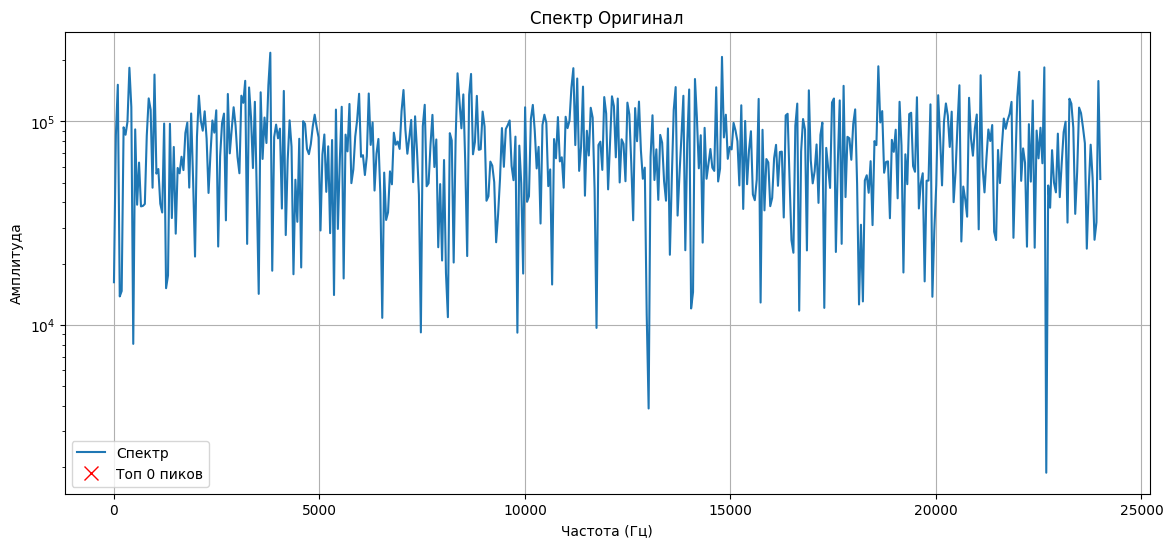

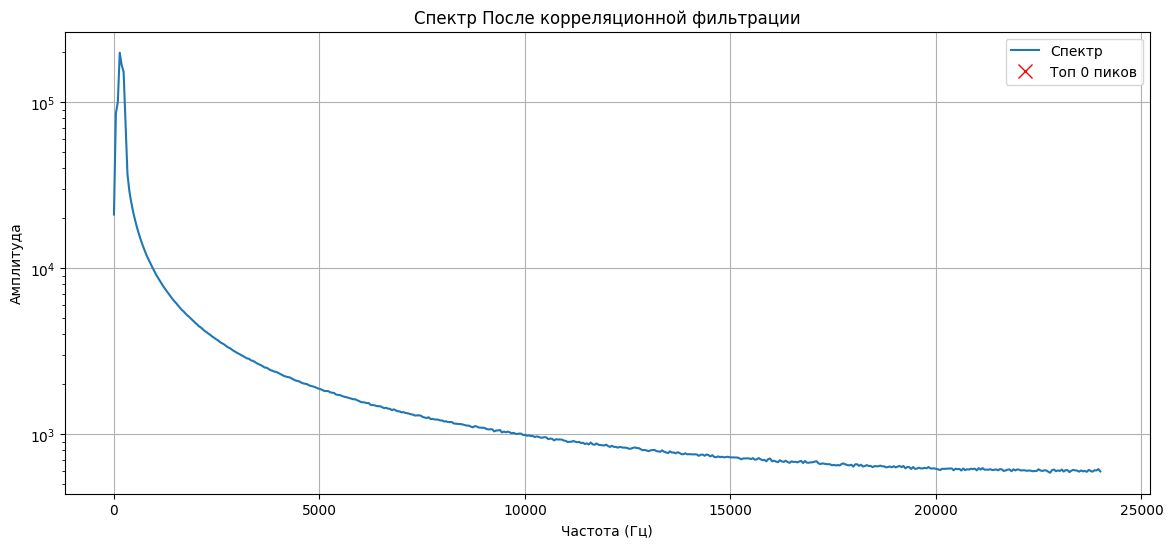

In [ ]:
plot_comparison(data1, cleaned_signal, rate1)

display(Audio(cleaned_signal, rate=rate1))
wavfile.write("data/cleaned_sound1.wav", rate2, cleaned_signal)

# corrupt_sound2

Спектр corrupt_sound2:


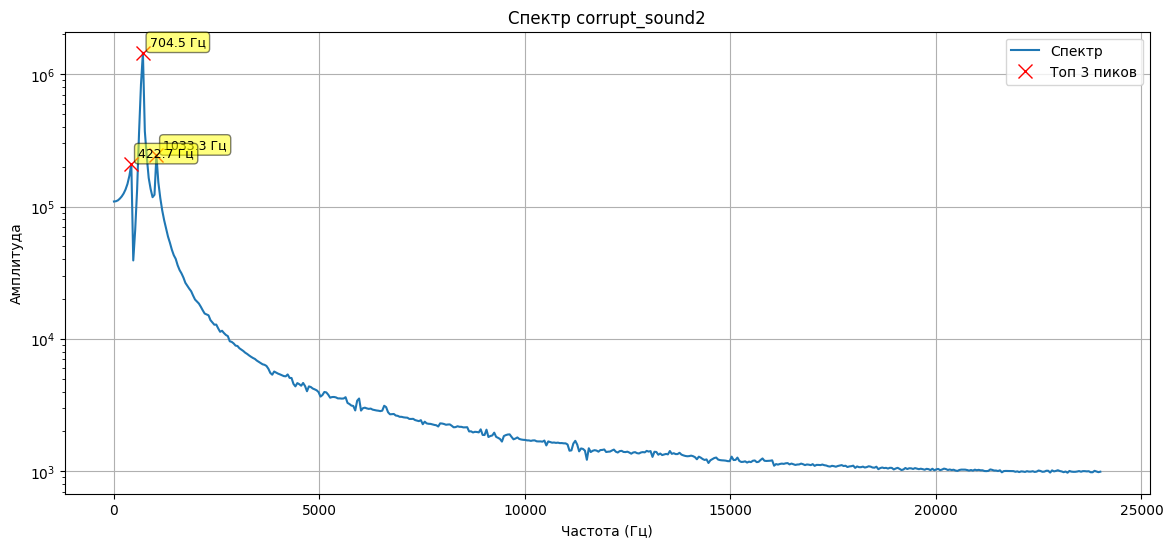

In [521]:
print("Спектр corrupt_sound2:")
peaks1,fft_spectrum1 = compute_and_plot_fft(data2, rate1, "corrupt_sound2",n_peaks=2)
cleaned_sound2 = process_signal(data2, rate1, noise_ranges=peaks1, bandwidth=100)
display(Audio(cleaned_sound2,rate=rate1))

peaks1,fft_spectrum1 = compute_and_plot_fft(cleaned_sound2, rate1, "corrupt_sound2",n_peaks=3)
cleaned_sound2 = process_signal(cleaned_sound2, rate1, noise_ranges=peaks1, bandwidth=100)
display(Audio(cleaned_sound2,rate=rate1))

<Figure size 1400x600 with 0 Axes>

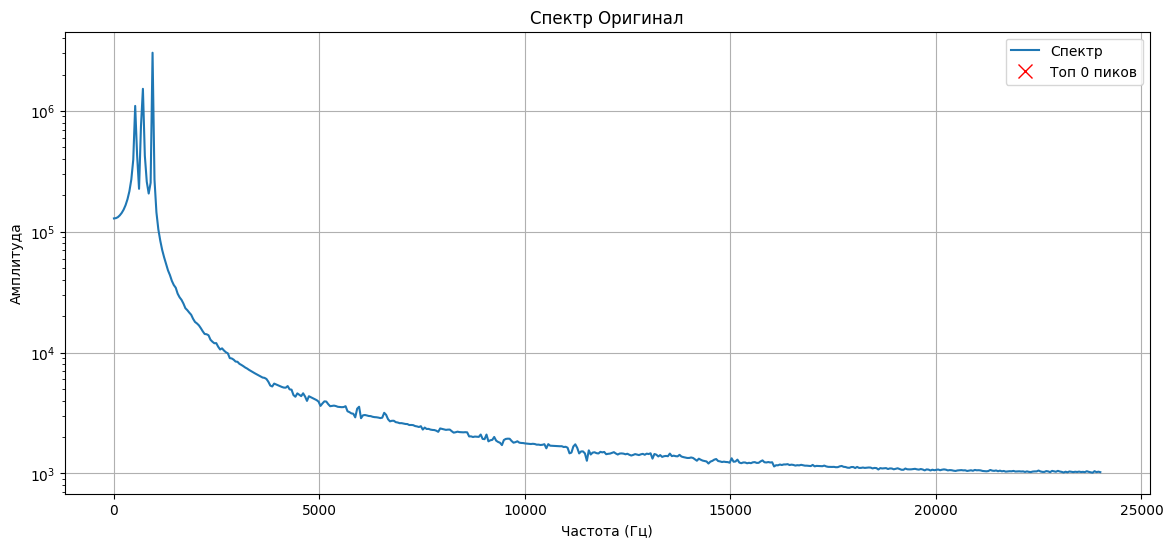

In [522]:
# Сравнение спектров до и после
# Без пиков
plt.figure(figsize=(14, 6))
compute_and_plot_fft(data2, rate2, "Оригинал", n_peaks=0)  
plt.show()
compute_and_plot_fft(cleaned_sound2, rate2, "После фильтрации", n_peaks=0)
plt.show()

In [523]:
wavfile.write("data/cleaned_sound2.wav", rate2, cleaned_sound2)